In [1]:
import os
import glob
import numpy as np
import xarray as xr

import matplotlib
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
%matplotlib inline
matplotlib.rcParams.update({'font.size':15})
import time

CMIP6_FOLDER = "/global/cfs/projectdirs/m3522/cmip6/"
SCRATCH="/global/cscratch1/sd/qnicolas/"

import sys
p = os.path.abspath('/global/homes/q/qnicolas/')
if p not in sys.path:
    sys.path.append(p)
    
from orographicPrecipitation.observationsAndERA5.mountainUtils import *; from tools.generalTools import *; from tools.BLtools import *

xr.set_options(display_style='text') 

In [ ]:
# Computing soundings of temperature and cross-slope wind for July in the Western Ghats

# Data loading

In [2]:
orogm=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_129_z.ll025sc.1979010100_1979010100.nc").Z.isel(time=0)/9.81
landmask=xr.open_dataset(CMIP6_FOLDER+"ERA5/e5.oper.invariant/197901/e5.oper.invariant.128_172_lsm.ll025sc.1979010100_1979010100.nc").LSM.isel(time=0)
gpm_pr_seasmean=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/GPM-IMERG-seasonalmean-200101-201812.nc")
era5100u=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_246_100u.2001-2018.nc")
era5100v=xr.open_dataarray("/global/cscratch1/sd/qnicolas/temp/e5.climatology.228_247_100v.2001-2018.nc")

In [3]:
box = [68,80,7.5,17]  
angle = 70
precipitating_month = 7
mountaintop=900. # abscissa of mountain top within rotated frame

box_tilted = [ 75  ,   9  ,  72.5, 16   ,2  ]
box_ref_rce = [68,71,11,15]            # Small, integer boxes to better assess mtn wave
box_ref_closeupstream = [72,73,12,17]  # Small, integer boxes to better assess mtn wave

Ghats = MountainRange('ghats',box,"Western Ghats",angle,precipitating_month,mountaintop)
Ghats.set_boxes(box_ref_rce,box_ref_closeupstream,box_tilted)

Ghats.set_2dvar('GPM_PR',gpm_pr_seasmean)
Ghats.set_2dvar('VAR_100U',era5100u)
Ghats.set_2dvar('VAR_100V',era5100v)
Ghats.set_2dvar('Z',orogm)
Ghats.set_uperp()

Ghats.set_3dvar('T',"128_130_t")
Ghats.set_3dvar('U',"128_131_u")
Ghats.set_3dvar('V',"128_132_v")
Ghats.set_3dvar('Q',"128_133_q")
Ghats.set_uperp3d()

Ghats.set_othervar('N',compute_N(Ghats.vars["T"],pfactor=100,pname='level'))

# Maps

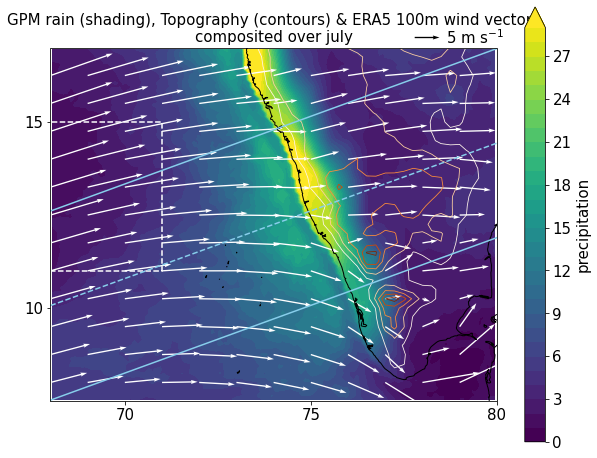

In [18]:
fig,ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={"projection":ccrs.PlateCarree()})
topography_pr_wind_plot(ax,Ghats.box,Ghats.vars['Z'],Ghats.vars['GPM_PR'],Ghats.vars['VAR_100U'],Ghats.vars['VAR_100V'],np.arange(0,30,1))

#Boxes
for smallbox,clr in ((Ghats.box_upstream,'w'),):
    ax.add_patch(mpatches.Rectangle(xy=[smallbox[0], smallbox[2]], width=smallbox[1]-smallbox[0], height=smallbox[3]-smallbox[2],
                                       edgecolor=clr,
                                       fill = False,
                                       lw=1.5,
                                       linestyle='--',
                                       transform=ccrs.PlateCarree())
                    )

alpha = np.tan(np.pi/2-np.pi*Ghats.angle/180)
x0,x1=box[0],box[1]; xm=(x0+x1)/2
y0,y1=box[2],box[3]; ym=(y0+y1)/2
fx = np.array([ym + alpha*(x0-xm),ym + alpha*(x1-xm)])
ax.plot([x0,x1],fx,color='skyblue',linestyle='--')
ax.plot([x0,x1],fx-(y1-y0)/4/np.cos(alpha),color='skyblue',linestyle='-')
ax.plot([x0,x1],fx+(y1-y0)/4/np.cos(alpha),color='skyblue',linestyle='-')

ax.set_title("GPM rain (shading), Topography (contours) & ERA5 100m wind vectors\ncomposited over july",fontsize=15);None


Text(0.5, 1.0, 'BV frequency climatology (s^-1)')

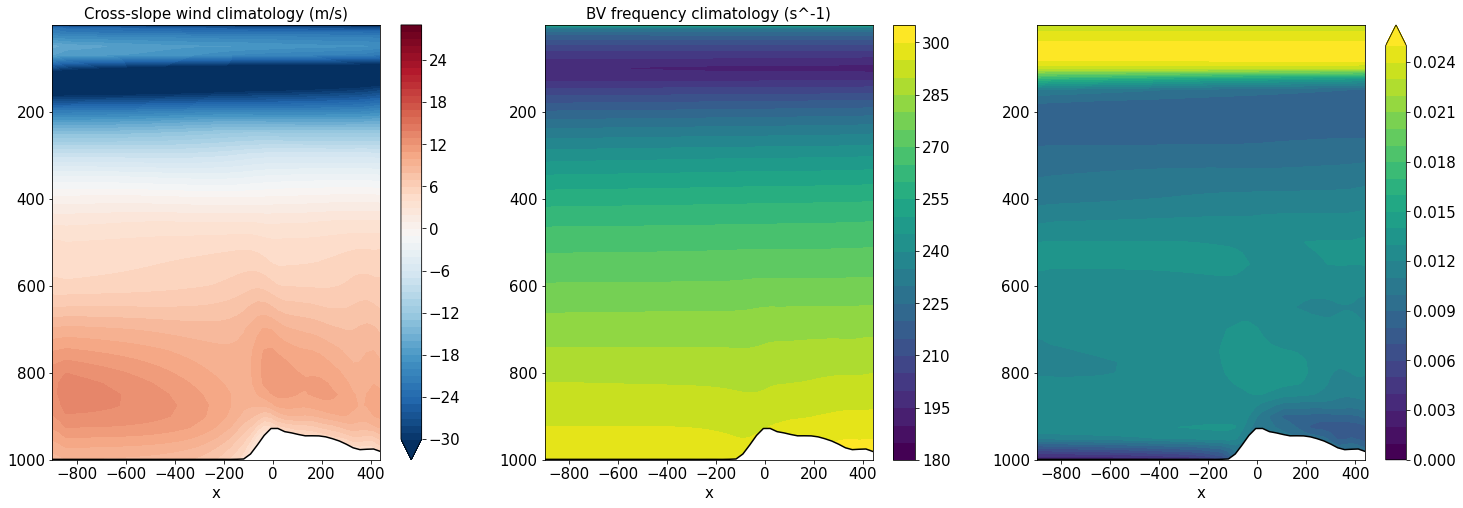

In [37]:
fig,ax = plt.subplots(1,3,figsize=(25,8))

plot_xz(ax[0],Ghats,'U_PERP',levels=np.arange(-30,30,1))
plot_xz(ax[1],Ghats,'T',levels=np.arange(180,310,5))
plot_xz(ax[2],Ghats,'N',levels=np.arange(0,0.026,0.001))


ax[0].set_title(r'Cross-slope wind climatology (m/s)',fontsize=15)
ax[1].set_title(r'T climatology (K)',fontsize=15)
ax[1].set_title(r'BV frequency climatology (s^-1)',fontsize=15)

# Interpolation & writing

In [62]:
geop="128_129_z"
stored_geopotential='/global/cscratch1/sd/qnicolas/regionsData/e5.climatology.%s.%s.2001-2019.nc'%(geop,"ghatsupstream")
#e5_climatology(geop,years=range(2010,2011),box=Ghats.box_upstream,level=None,chunks=None,month=Ghats.pr_month).to_netcdf(stored_geopotential)
Ghats_Z_upstream      = xr.open_dataarray(stored_geopotential).mean(['latitude','longitude'])/9.81
Ghats_T_upstream      = sel_box_month(Ghats.vars["T"     ],Ghats.box_upstream,0).mean(['latitude','longitude'])
Ghats_Q_upstream      = sel_box_month(Ghats.vars["Q"     ],Ghats.box_upstream,0).mean(['latitude','longitude'])
Ghats_U_PERP_upstream = sel_box_month(Ghats.vars["U_PERP"],Ghats.box_upstream,0).mean(['latitude','longitude'])
Ghats_THETA_upstream  = Ghats_T_upstream*(Ghats_T_upstream.level/1000.)**(-0.286)

In [63]:
Ghats_Z_upstream      = np.array(Ghats_Z_upstream     )[::-1]
Ghats_Q_upstream      = np.array(Ghats_Q_upstream     )[::-1]
Ghats_U_PERP_upstream = np.array(Ghats_U_PERP_upstream)[::-1]
Ghats_THETA_upstream  = np.array(Ghats_THETA_upstream )[::-1]

In [68]:
SCRATCH='/global/cscratch1/sd/qnicolas/'

### MODIFY HERE ###
outfile = "WRF/WRFV4_gw/test/em_beta_plane/input_sounding"
###################

z = np.arange(0.,35000,50.)
thetaz = np.interp(z,Ghats_Z_upstream,Ghats_THETA_upstream)
qz = np.interp(z,Ghats_Z_upstream,Ghats_Q_upstream)
uz = np.interp(z,Ghats_Z_upstream,Ghats_U_PERP_upstream)


i=0
f = open(SCRATCH+outfile, "w")
print('{:>10.2f}{:>10.2f}{:>10.2f}'.format(1000.,thetaz[0],1000*qz[0]),file=f)
for i,zz in enumerate(z):
    print('{:>10.2f}{:>10.2f}{:>10.2f}{:>10.2f}{:>10.2f}'.format(zz,thetaz[i],1000*qz[i],uz[i],0.),file=f)
f.close()

# Ghats topography

In [16]:
box = [68,85,7.5,17]  
angle = 70
precipitating_month = 7
mountaintop=900. # abscissa of mountain top within rotated frame

Ghatswide = MountainRange('ghats',box,"Western Ghats",angle,precipitating_month,mountaintop)
Ghatswide.set_2dvar('GPM_PR',gpm_pr_seasmean)
Ghatswide.set_2dvar('VAR_100U',era5100u)
Ghatswide.set_2dvar('VAR_100V',era5100v)
Ghatswide.set_2dvar('Z',orogm)

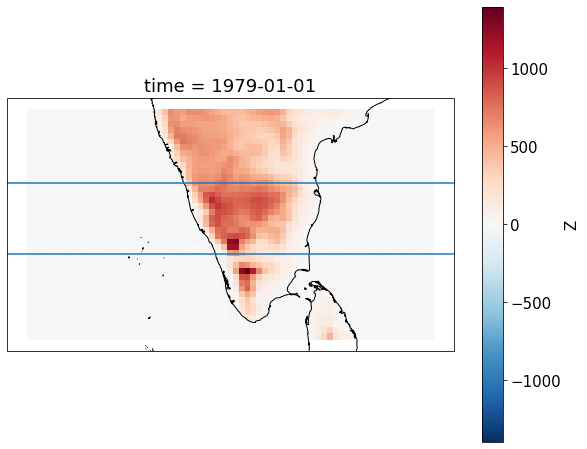

In [15]:
fig,ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={"projection":ccrs.PlateCarree()})
box = [68,85,7.5,17]  

sel_box_month(orogm,box,0).plot(ax=ax,transform=ccrs.PlateCarree())
ax.axhline(11)
ax.axhline(14)
ax.coastlines()

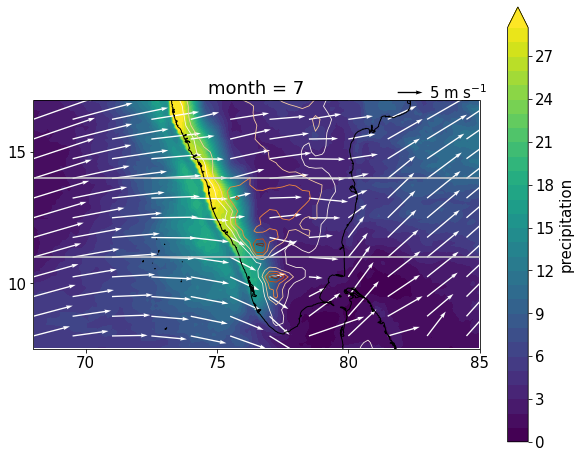

In [21]:
fig,ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={"projection":ccrs.PlateCarree()})
topography_pr_wind_plot(ax,Ghatswide.box,Ghatswide.vars['Z'],Ghatswide.vars['GPM_PR'],Ghatswide.vars['VAR_100U'],Ghatswide.vars['VAR_100V'],np.arange(0,30,1))
ax.axhline(11,color='lightgrey')
ax.axhline(14,color='lightgrey')

Text(0.5, 0, 'Zonal distance from peak (km) ')

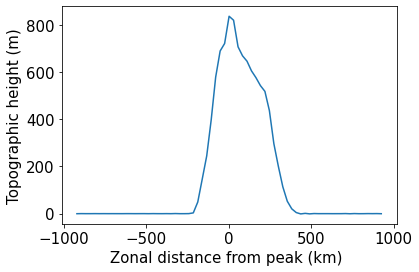

In [34]:
ghats_topo = np.array(Ghatswide.vars['Z'].sel(latitude=slice(14,11)).mean('latitude'))
ghats_dx = np.cos(12.5*np.pi/180)*6370*0.25*np.pi/180
ghats_x = ghats_dx*np.arange(len(ghats_topo)) - 920
plt.plot(ghats_x,ghats_topo)
plt.ylabel('Topographic height (m)')
plt.xlabel('Zonal distance from peak (km) ')

In [37]:
SCRATCH='/global/cscratch1/sd/qnicolas/'

### MODIFY HERE ###
outfile = "WRF/WRFV4_gw/test/em_beta_plane/input_topo"
###################

i=0
f = open(SCRATCH+outfile, "w")
print('{:>10.2f}{:>10.2f}'.format(-5000.,0.),file=f)
for x,ht in zip(ghats_x,ghats_topo):
    if ht<2:
        ht=0
    print('{:>10.2f}{:>10.2f}'.format(x,ht),file=f)
print('{:>10.2f}{:>10.2f}'.format(5000.,0.),file=f)
f.close()